In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

data= pd.read_csv("/content/drive/MyDrive/Cyberbullying_Kaggle_Data/cyberbullying_tweets.csv")

In [80]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


**Phase 1: EDA to see distribution of** **Tweets**

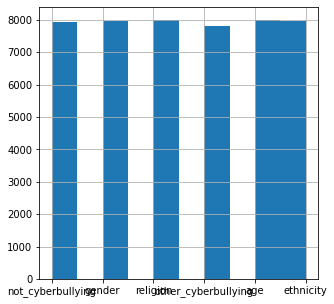

In [81]:
#Distribution of tweets
data.cyberbullying_type.hist() #Histogram shows that the dataset is balanced and has equal representation for all labels

In [82]:
temp = data.groupby('cyberbullying_type').count().reset_index().sort_values(by='tweet_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,cyberbullying_type,tweet_text
5,religion,7998
0,age,7992
2,gender,7973
1,ethnicity,7961
3,not_cyberbullying,7945
4,other_cyberbullying,7823


In [83]:
#Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp,
    values = temp.tweet_text,
    title = {"position": "top center", "text": "Funnel-Chart of Bullying Type Distribution"}
    ))
fig.show()

**Word Cloud of tweets for EDA**

In [84]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [85]:
text = " ".join(review for review in data.tweet_text)

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update([])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

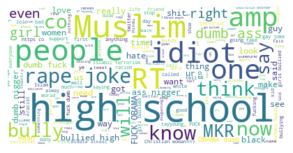

In [86]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

**Phase 2: Building a base model for multi-class classification**

**TEXT PREPROCESSING** functions defintion:

In [87]:
# import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Create a reference variable for Class WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

#Preprocessing: Tweet Tokenizer + lowercase conversion
def LC_tokeniser(df):
  df["tokens"]= df["tweet_text"].apply(lambda x: tk.tokenize(x.lower()))
  return df
#Recover Hashtags
def hashtag(df):
  df["hastags"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("#")])
  return df
#Recover Mentions @
def mentions(df):
  df["mentions"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("@")])
  return df
#number of words in a tweet
def length(df):
  df["length"]= df["tokens"].apply(lambda x: len(x))
  return df

#Remove Stop-words
def remove_stopwords(df):
  df['remove_stopwords'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
  return df

#Lemmatisation to get root words and remove numbers if any!
def lemmatise(df):
  df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x if y.isalpha()]) 
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [88]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [89]:
#Function definition for Topic Modelling based on tweet's comments
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def LDA(df, n=10):
  # initisalise LDA Model
  lda_model = LatentDirichletAllocation(n_components = n, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))
  
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  vectorised = vectorizer.fit_transform(vectors)
  
  lda_output = lda_model.fit_transform(vectorised)

# column names
  topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
  df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
  dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
  df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
  df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
  df['Dominant_topic']=df['Dominant_topic'].astype(int)

  return df

In [90]:
#Bag of Vectors
from sklearn.feature_extraction.text import CountVectorizer
def bow(df):
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  # join the processed data to be vectorised
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))

  vectorised = vectorizer.fit_transform(vectors)
  return vectorised

Feature Engineering - BOWs and TF-IDF

In [91]:
'''from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

Model1 = Pipeline([("Lower_case_Tokenizer",LC_tokeniser()),("Getting_Hashtags",hastag()),("length_of_tweet",length()),("RemoveStopWords", remove_stopwords()),("Lemmatise",lemmatise()),("tfidf", TfidfVectorizer()),("clf", MultinomialNB())])
Model1.fit(x_train, y_train)
Model1.score(x_test, y_test)
'''

'from sklearn.naive_bayes import MultinomialNB\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nModel1 = Pipeline([("Lower_case_Tokenizer",LC_tokeniser()),("Getting_Hashtags",hastag()),("length_of_tweet",length()),("RemoveStopWords", remove_stopwords()),("Lemmatise",lemmatise()),("tfidf", TfidfVectorizer()),("clf", MultinomialNB())])\nModel1.fit(x_train, y_train)\nModel1.score(x_test, y_test)\n'

**Feature Engineering**

Split data into train and test

In [92]:
from sklearn.model_selection import train_test_split
df= LC_tokeniser(data)
df= hashtag(df)
df= mentions(df)
df= length(df)
df= remove_stopwords(df)
df= lemmatise(df)
df["hashtags_present"]=df["hastags"].apply(lambda x: int((len(x)>0)))
df["mentions_present"]= df["mentions"].apply(lambda x:int((len(x)>0)))
df.head()

,tweet_text,cyberbullying_type,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1


In [93]:
df= LDA(df)

In [111]:
df["lemma_sentence"]= df["lemmatise"].apply(lambda x: " ".join(str(w) for w in x))
df.head()

,tweet_text,cyberbullying_type,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present,...,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic,lemma_sentence
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.01,9,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0,...,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,4,white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1,...,0.01,0.01,0.92,0.01,0.01,0.01,0.01,0.01,5,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1,...,0.01,0.95,0.01,0.01,0.01,0.01,0.01,0.01,4,isi account pretending kurdish account like is...


In [112]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [114]:
from sklearn.feature_extraction.text import TfidfTransformer

#Categrical features to pass down the categorical pipeline 
categorical_features = ['mentions_present', 'hashtags_present', 'Dominant_topic']

#Numerical features to pass down the numerical pipeline 
numerical_features = ['length']

#Textual features to pass down the numerical pipeline 
text_features = ['lemma_sentence']

#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),                                  
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),
                                        ('imputer', SimpleImputer(strategy = 'median') ),
                                        ('std_scaler', StandardScaler() ) ] )
#Defining the steps in the Text (Tweets) pipeline 
tweet_pipeline = Pipeline( steps = [ ( 'text_selector', FeatureSelector(text_features) ),                                 
                                  ( 'Count Vectorizer', CountVectorizer(stop_words='english') ),
                                  ('tfidf', TfidfTransformer()) ] )

#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  ( 'numerical_pipeline', numerical_pipeline ) ,
                                                   ( 'text_pipeline', tweet_pipeline )])

In [134]:
x = df.iloc[:,2:22]
y = df['cyberbullying_type']

In [135]:
numerical_ix= [3,8,9,10,11,12,13,14,15,16,17]
categorical_ix= [6,7,18]
text_ix=[19]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tokens            47692 non-null  object 
 1   hastags           47692 non-null  object 
 2   mentions          47692 non-null  object 
 3   length            47692 non-null  int64  
 4   remove_stopwords  47692 non-null  object 
 5   lemmatise         47692 non-null  object 
 6   hashtags_present  47692 non-null  int64  
 7   mentions_present  47692 non-null  int64  
 8   Topic1            47692 non-null  float64
 9   Topic2            47692 non-null  float64
 10  Topic3            47692 non-null  float64
 11  Topic4            47692 non-null  float64
 12  Topic5            47692 non-null  float64
 13  Topic6            47692 non-null  float64
 14  Topic7            47692 non-null  float64
 15  Topic8            47692 non-null  float64
 16  Topic9            47692 non-null  float6

In [145]:
from sklearn.compose import ColumnTransformer

t = [('cat', OneHotEncoder(), categorical_ix), ('std_scaler', StandardScaler(), numerical_ix),( 'Count Vectorizer', CountVectorizer(stop_words='english'),text_ix ),
                                  ('tfidf', TfidfTransformer(),text_ix)]
col_transform = ColumnTransformer(transformers=t)
text_transform = ColumnTransformer(transformers=[( 'CountVectorizer', CountVectorizer(stop_words='english'),text_ix )])

In [146]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split( x, y , test_size = 0.2 , random_state = 42 )

#The full pipeline
full_pipeline_m = Pipeline( steps = [ ( 'transformer', text_transform),
                                     ("clf", RandomForestClassifier(n_estimators=200))] )

#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict(X_test ) 

ValueError: ignored

In [ ]:
full_pipeline_m.score(X_test, y_test)

In [ ]:
x = df.iloc[:,[4,7,8,9,10,11,12,13,14,15,16]]
y = df['cyberbullying_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train[:5]

In [ ]:
y_train[:5]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Model_Knn = Pipeline([("clf", KNeighborsClassifier())])
Model_Knn.fit(x_train, y_train)
Model_Knn.score(x_test, y_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred= Model_Knn.predict(x_test)

print("Classification report for KNN':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for KNN:",accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

Model1 = Pipeline([("clf", MultinomialNB())])
Model1.fit(x_train, y_train)
Model1.score(x_test, y_test)

y_pred= Model1.predict(x_test)

print("Classification report for Multinomial Naive Bayes':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Multinomial Naive Bayes':",accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ModelRf2 = Pipeline([("clf", RandomForestClassifier(n_estimators=200))])
ModelRf2.fit(x_train, y_train)
ModelRf2.score(x_test, y_test)

In [ ]:
#Random Forest
y_pred= ModelRf2.predict(x_test)

print("Classification report for Random Forest:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Random Forest:",accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import train_test_split
df["lemmatised sentence"]= df["lemmatise"].apply(lambda x: " ".join(word for word in x))
x = df['lemmatised sentence']
y = df['cyberbullying_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train.head()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Model1 = Pipeline([("BOWs", CountVectorizer()),("clf", MultinomialNB())])
Model1.fit(x_train, y_train)
print(Model1.score(x_test, y_test))


Model2 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])
Model2.fit(x_train, y_train)
print(Model2.score(x_test, y_test))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Model_Knn = Pipeline([("BOWs", CountVectorizer()), ("clf", KNeighborsClassifier())])
Model_Knn.fit(x_train, y_train)
Model_Knn.score(x_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ModelRf1 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", RandomForestClassifier(n_estimators=100))])
ModelRf1.fit(x_train, y_train)
ModelRf1.score(x_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ModelRf2 = Pipeline([("BOWs", CountVectorizer()), ("clf", RandomForestClassifier(n_estimators=100))])
ModelRf2.fit(x_train, y_train)
ModelRf2.score(x_test, y_test)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
Modelxgb = Pipeline([("BOWs", CountVectorizer()), ("clf", XGBClassifier())])
Modelxgb.fit(x_train, y_train)
Modelxgb.score(x_test, y_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= Modelxgb.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))

In [ ]:
#Random Forest
y_pred= ModelRf1.predict(x_test)

print("Classification report for Random Forest:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Random Forest:",accuracy_score(y_test, y_pred))

In [ ]:
y_pred= Model2.predict(x_test)

print("Classification report for Multinomial Naive Bayes':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Multinomial Naive Bayes':",accuracy_score(y_test, y_pred))

In [ ]:
y_pred= Model_Knn.predict(x_test)

print("Classification report for KNN':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for KNN:",accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

Model_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
Model_sgd.fit(x_train, y_train)
Model_sgd.score(x_test, y_test)

y_pred = Model_sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('XGBoost', XGBClassifier()), ('RF', RandomForestClassifier()), ('MNB',MultinomialNB() ), ("SGD", SGDClassifier(alpha=1e-3, random_state=42, max_iter=5, tol=None))],voting='hard', weights=[3,2,1,1])
Model_Voting =  Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', eclf),
               ])
Model_Voting.fit(x_train, y_train)
y_pred= Model_Voting.predict(x_test)

print("Classification report for Ensemble Classifier':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Ensemble Classifier:",accuracy_score(y_test, y_pred))

In [ ]:
#Placeholdder functions
'''Model_Voting_2 =  Pipeline([("tokeniser",TweetTokenizer()),("lowercase", lower()), ("lemmatise", lemmatizer()), ('vect', CountVectorizer(stop_words='english'))
                ('tfidf', TfidfTransformer()),
                ('clf', eclf),
               ])
Model_Voting.fit(x_train, y_train)
y_pred= Model_Voting.predict(x_test)

print("Classification report for Ensemble Classifier':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Ensemble Classifier:",accuracy_score(y_test, y_pred))'''

In [ ]:
'''## Lemmatisation (convert the word into root word)

    if flg_lemm == True:

        lem = nltk.stem.wordnet.WordNetLemmatizer()

        lst_text = [lem.lemmatize(word) for word in lst_text]

def   utils_preprocess_text ( text ,  flg_s... by Kavya Shirke (Student at CentraleSupelec)
Kavya Shirke (Student at CentraleSupelec)16:54
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    ## clean (convert to lowercase and remove punctuations and characters and then strip)

    text = re.sub(r'[^\w\s]', '', str(df.tweet_text).lower().strip())

            

    ## Tokenize (convert from string to list)

    lst_text = df.tweet_text.split()

    ## remove Stopwords

    if lst_stopwords is not None:

        lst_text = [word for word in lst_text if word not in 

                    lst_stopwords]

                

    ## Stemming (remove -ing, -ly, ...)

    if flg_stemm == True:

        ps = nltk.stem.porter.PorterStemmer()

        lst_text = [ps.stem(word) for word in lst_text]

                

    ## Lemmatisation (convert the word into root word)

    if flg_lemm == True:

        lem = nltk.stem.wordnet.WordNetLemmatizer()

        lst_text = [lem.lemmatize(word) for word in lst_text]

            

    ## back to string from list

    text = " ".join(lst_text)

    return text
'''
